# Setup

In [ ]:
import os
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=8"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 8.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Dataset

In [ ]:
import pandas as pd
cols = ['preprocess', 'label',
        'NEG', 'POS', 'NEU',
        'num_word', 'num_char', 'num_hashtag', 'num_url',
        'num_like_post', 'num_comment_post', 'num_share_post',
        'hour', 'weekday', 'day', 'month', 'year']
df = pd.read_csv('/content/drive/Shareddrives/[NCKH] /CODE/DATA/data_after_preprocessing_text_sa_timestamp_numeric.csv', usecols=cols)

In [ ]:
df = df.reindex(columns=cols)

In [ ]:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4106 entries, 0 to 4105
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   preprocess        4106 non-null   object 
 1   label             4106 non-null   int64  
 2   NEG               4106 non-null   float64
 3   POS               4106 non-null   float64
 4   NEU               4106 non-null   float64
 5   num_word          4106 non-null   int64  
 6   num_char          4106 non-null   int64  
 7   num_hashtag       4106 non-null   int64  
 8   num_url           4106 non-null   int64  
 9   num_like_post     4106 non-null   float64
 10  num_comment_post  4106 non-null   float64
 11  num_share_post    4106 non-null   float64
 12  hour              4106 non-null   int64  
 13  weekday           4106 non-null   int64  
 14  day               4106 non-null   int64  
 15  month             4106 non-null   int64  
 16  year              4106 non-null   int64  


,preprocess,label,NEG,POS,NEU,num_word,num_char,num_hashtag,num_url,num_like_post,num_comment_post,num_share_post,hour,weekday,day,month,year
0,cần các bậc phụ_huynh xã ngũ thái lên_tiếng kh...,1,0.985327,0.004864,0.009808,34,182,0,0,45.0,15.0,8.0,6,1,17,3,2020
1,kêu_gọi ăn_chay cầu_nguyện xin chúa cứu khỏi d...,1,0.659123,0.213645,0.127232,10,62,0,0,979.0,39.0,138.0,19,0,10,2,2020
2,giàn khoan dầu_khí gặp sự_cố chết người giàn k...,1,0.929886,0.016793,0.053320,41,212,0,0,85.0,13.0,61.0,12,3,16,4,2020
3,thuận_lợi có ca dương_tính cv19 rồi đó mọi ngư...,1,0.004563,0.982044,0.013393,28,151,0,0,114.0,12.0,5.0,10,0,3,8,2020
4,sa_pa cho 9 người khách nước_ngoài đi cùng chu...,1,0.038136,0.090191,0.871673,13,65,0,0,166.0,4.0,21.0,2,5,7,3,2020


In [ ]:
pd.DataFrame(df['label'].value_counts())

,label
0,3348
1,758


# Data Normalization

In [ ]:
numerical_cols = ['NEG', 'POS', 'NEU',
                  'num_word', 'num_char', 'num_hashtag', 'num_url',
                  'num_like_post', 'num_comment_post', 'num_share_post',
                  'hour', 'weekday', 'day', 'month', 'year']

for col in numerical_cols:
    scale = StandardScaler().fit(df[[col]])
    df[col] = scale.transform(df[[col]])

In [ ]:
df.head()

,preprocess,label,NEG,POS,NEU,num_word,num_char,num_hashtag,num_url,num_like_post,num_comment_post,num_share_post,hour,weekday,day,month,year
0,cần các bậc phụ_huynh xã ngũ thái lên_tiếng kh...,1,1.331592,-0.750723,-0.876529,-0.452903,-0.471984,-0.255596,-0.370426,-0.260416,-0.164019,-0.272612,-0.498758,-0.921436,0.114819,-1.040428,0.101316
1,kêu_gọi ăn_chay cầu_nguyện xin chúa cứu khỏi d...,1,0.558540,-0.181946,-0.517057,-0.889199,-0.873580,-0.255596,-0.370426,-0.128228,-0.127808,-0.196787,1.367536,-1.435417,-0.728774,-1.789376,0.101316
2,giàn khoan dầu_khí gặp sự_cố chết người giàn k...,1,1.200206,-0.718224,-0.743326,-0.325650,-0.371585,-0.255596,-0.370426,-0.254755,-0.167036,-0.241699,0.362609,0.106527,-0.005694,-0.291480,0.101316
3,thuận_lợi có ca dương_tính cv19 rồi đó mọi ngư...,1,-0.992660,1.911386,-0.865556,-0.561977,-0.575729,-0.255596,-0.370426,-0.250650,-0.168545,-0.274362,0.075487,-1.435417,-1.572368,2.704311,0.101316
4,sa_pa cho 9 người khách nước_ngoài đi cùng chu...,1,-0.913098,-0.518269,1.761914,-0.834662,-0.863540,-0.255596,-0.370426,-0.243291,-0.180615,-0.265029,-1.073002,1.134489,-1.090314,-1.040428,0.101316


#Function

In [ ]:
def get_metrics(y_test, y_pred_proba):
    print('ACCURACY_SCORE: ', round(accuracy_score(y_test, y_pred_proba>=0.5), 4), '\n')
    print('ROC_AUC_SCORE: ', round(roc_auc_score(y_test, y_pred_proba), 4), '\n')
    print('F1_SCORE: ', round(f1_score(y_test, y_pred_proba>=0.5, average='macro'), 4), '\n')
    print('CONFUSION_MATRIX:\n', confusion_matrix(y_test, y_pred_proba>=0.5),'\n')

In [ ]:
def get_numeric_data(x):
    return [record[1:].astype(float) for record in x]

def get_text_data(x):
    return [record[0] for record in x]

transfomer_numeric = FunctionTransformer(get_numeric_data)
transformer_text = FunctionTransformer(get_text_data)

In [ ]:
tfidf = TfidfVectorizer(max_features=100000, ngram_range=(1,2))

# Split data

In [ ]:
from sklearn.model_selection import train_test_split
labels=df['label']
x_train, x_test, y_train, y_test = train_test_split(df['preprocess'], labels, test_size=0.2, random_state=42)

# In số lượng mẫu trong từng phần
print("Số mẫu trong tập train:", len(x_train))
print("Số mẫu trong tập test:", len(x_test))

Số mẫu trong tập train: 3284
Số mẫu trong tập test: 822


# Data Pretrain

In [ ]:
print(x_train)

3920    tại_sao trung_quốc kiên_quyết không công_bố số...
2804    quá thương_tâm phó chủ_tịch ubnd quận bình_tân...
2639    ông trump cho rằng trung_quốc lẽ_ra phải thông...
2183    các tài_liệu ngoại_giao mật yêu_cầu quan_chức ...
67      kết_quả thăm_dò cho thấy 96 cho rằng trên 100 ...
                              ...                        
3444    ông adam segal chuyên_gia về an_ninh mạng của ...
466     🛒 🏨 🏪 các cơ_sở kinh_doanh thương_mại dịch_vụ ...
3092    dù ai xuống phố lên đàng nhớ ngày công_bố bảng...
3772                 công_an tỉnh yên_bái có giám_đốc mới
860     trước tình_hình loạn giá khan_hiếm khẩu_trang ...
Name: preprocess, Length: 3284, dtype: object


In [ ]:
print(x_test)

2471    công phượng gửi tin_vui tới thầy park khi duyê...
564     xứ thanh kỳ ghê cục trưởng cục thi_hành án dân...
731     hôm_nay 10 3 âm_lịch là ngày giỗ tổ hùng vương...
1073    dịch covid 19 không phải tận_thế đừng ai lo đế...
3015    nóng khởi_tố bắt tạm giam giám_đốc đơn_vị thi_...
                              ...                        
2147    giữa bối_cảnh ngành hàng_không đang điêu_đứng ...
254     tôi yêu việt_nam chẳng nơi nào như nước việt t...
2771    trực_tiếp chọn ngành học tương_lai khối ngành ...
2304    uỷ_viên quốc vụ kiêm ngoại_trưởng trung_quốc v...
1543    trận đấu siêu kinh_điển giữa 2 ông vua làng bi...
Name: preprocess, Length: 822, dtype: object


In [ ]:
x_train = tfidf.fit_transform(x_train)
x_test = tfidf.transform(x_test)
y_train = y_train.values
y_test = y_test.values

print(x_train.shape)
print(x_test.shape)

(3284, 100000)
(822, 100000)


In [ ]:
print(x_train[0])

  (0, 38541)	0.16624665776159947
  (0, 70974)	0.2250989125086124
  (0, 24708)	0.2250989125086124
  (0, 99699)	0.2250989125086124
  (0, 87001)	0.2250989125086124
  (0, 88189)	0.2142386044274347
  (0, 87160)	0.2250989125086124
  (0, 73549)	0.15968109796713348
  (0, 69184)	0.2250989125086124
  (0, 64502)	0.2250989125086124
  (0, 19554)	0.2250989125086124
  (0, 36820)	0.2250989125086124
  (0, 37740)	0.2005562343814812
  (0, 73809)	0.2250989125086124
  (0, 78901)	0.2250989125086124
  (0, 18385)	0.054299458205746116
  (0, 38480)	0.05795427580658796
  (0, 70969)	0.16211776025508354
  (0, 24682)	0.1363290520956928
  (0, 99696)	0.16624665776159947
  (0, 86589)	0.06468568638124976
  (0, 88188)	0.2142386044274347
  (0, 87069)	0.10175027908503502
  (0, 73223)	0.057902114513719266
  (0, 69182)	0.20653309321628366
  (0, 64495)	0.16479847721943613
  (0, 19519)	0.11952437131519657
  (0, 36746)	0.06055678887473383
  (0, 37739)	0.19567278513510594
  (0, 73762)	0.10284368867346218
  (0, 78881)	0.15538634

# Train and evaluate


In [ ]:
model = LGBMClassifier()
model.fit(x_train, y_train)
y_pred_proba = model.predict_proba(x_test) [:,1]
get_metrics(y_test, y_pred_proba)

[LightGBM] [Info] Number of positive: 598, number of negative: 2686
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039428 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37593
[LightGBM] [Info] Number of data points in the train set: 3284, number of used features: 1497
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.182095 -> initscore=-1.502218
[LightGBM] [Info] Start training from score -1.502218
ACCURACY_SCORE:  0.8771 

ROC_AUC_SCORE:  0.8866 

F1_SCORE:  0.7714 

CONFUSION_MATRIX:
 [[640  22]
 [ 79  81]] 



# Table score

In [ ]:
list_model = [LogisticRegression(solver='liblinear'),
              SVC(kernel = 'linear', probability = True),
              LGBMClassifier(), XGBClassifier(), CatBoostClassifier(verbose = 200)]

list_model_name, list_acc_score, list_f1_score, list_roc_auc = [], [], [], []

In [ ]:
for model in list_model:
    print(f"{type(model).__name__} .....\n")
    model.fit(x_train, y_train)
    y_pred_proba = model.predict_proba(x_test) [:,1]
    list_model_name.append(type(model).__name__);
    list_acc_score.append(accuracy_score(y_test, y_pred_proba>=0.5))
    list_f1_score.append(f1_score(y_test, y_pred_proba>=0.5, average='macro'))
    list_roc_auc.append(roc_auc_score(y_test, y_pred_proba))

LogisticRegression .....

SVC .....

LGBMClassifier .....

[LightGBM] [Info] Number of positive: 598, number of negative: 2686
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040047 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37593
[LightGBM] [Info] Number of data points in the train set: 3284, number of used features: 1497
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.182095 -> initscore=-1.502218
[LightGBM] [Info] Start training from score -1.502218
XGBClassifier .....

CatBoostClassifier .....

Learning rate set to 0.017117
0:	learn: 0.6842246	total: 931ms	remaining: 15m 30s
200:	learn: 0.3579762	total: 1m 39s	remaining: 6m 36s
400:	learn: 0.3092099	total: 3m 15s	remaining: 4m 52s
600:	learn: 0.2677506	total: 4m 52s	remaining: 3m 14s
800:	learn: 0.2302316	total: 6m 29s	remaining: 1m 36s
999:	learn: 0.2010775	total: 8m 6s	rema

In [ ]:
table_cols = {'Model name': list_model_name, 'Accuracy score': list_acc_score,
              'Macro-F1 score': list_f1_score, 'ROC-AUC score': list_roc_auc}
table = pd.DataFrame(table_cols)
table = table.sort_values(by=['ROC-AUC score'], ascending=False).reset_index(drop=True)
table

,Model name,Accuracy score,Macro-F1 score,ROC-AUC score
0,SVC,0.896594,0.836248,0.914785
1,LogisticRegression,0.834550,0.587769,0.903522
2,LGBMClassifier,0.877129,0.771417,0.886622
3,CatBoostClassifier,0.862530,0.719475,0.874339
4,XGBClassifier,0.867397,0.754818,0.853961


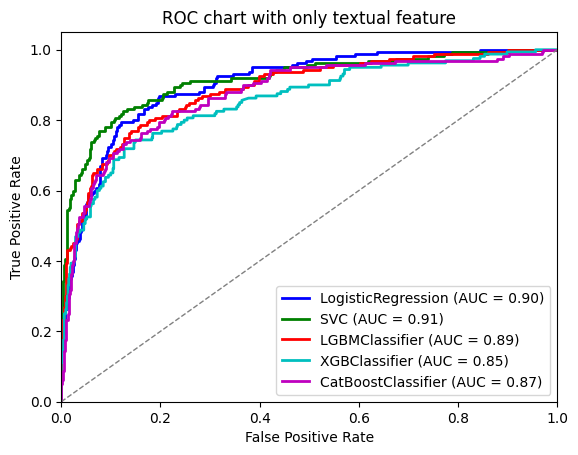

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Tạo một mảng chứa màu sắc cho các đường ROC
colors = ['b', 'g', 'r', 'c', 'm']

# Vẽ biểu đồ ROC-AUC cho từng mô hình trong danh sách
for i, model in enumerate(list_model):
    y_pred_proba = model.predict_proba(x_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # Vẽ đường ROC
    plt.plot(fpr, tpr, color=colors[i], lw=2, label=f'{list_model_name[i]} (AUC = {roc_auc:.2f})')

# Vẽ đường thẳng tham chiếu
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

# Cấu hình biểu đồ
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC chart with only textual feature')
plt.legend(loc='lower right')

# Hiển thị biểu đồ ROC-AUC
plt.show()